In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import pearsonr
import pandas as pd

import sys
sys.path.append('../../src/')
from coal_cov import *
from seg_sites_covar import CorrSegSites
from draw_demography import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

# Deboxing a particular axis
def debox(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
def plot_yx(ax, **kwargs):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, **kwargs)
    
def colorbar(mappable, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, **kwargs)
    plt.sca(last_axes)
    return cbar


import os
main_figdir = '../../plots/two_locus_stats/'
supp_figdir = '../../plots/supp_figs/two_locus_stats/'
os.makedirs(main_figdir, exist_ok=True)
os.makedirs(supp_figdir, exist_ok=True)

# Reading in mulitple demographies for two-locus simulations

In [3]:
def estNe(t2s):
    """Given modern estimate of t2s calculate Ne
    """
    return(np.mean(t2s)/2./2.)

In [4]:
def plot_bot_demo(ax, N0=1e4, T_bot=100, b=0.1, **kwargs):
    """Plot bottleneck demography
    """
    xs = np.arange(0, int(10*T_bot))
    ns = np.repeat(N0, xs.size)
    ns[T_bot:] = N0*b
    ax.plot(xs,ns, **kwargs)

100%|██████████| 3/3 [00:00<00:00, 190.99it/s]


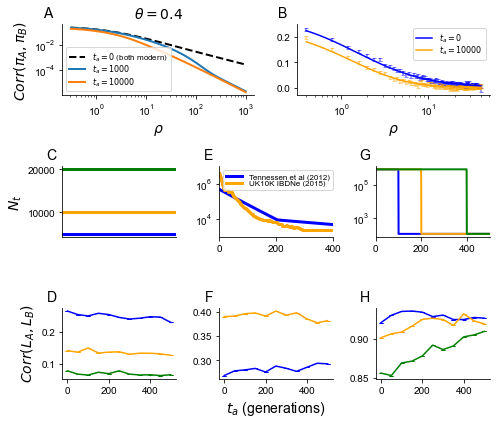

In [7]:
fig = plt.figure(figsize=(7,6), tight_layout=True)
gs = fig.add_gridspec(3, 6)

ax1 = fig.add_subplot(gs[0,:3]); debox(ax1)

# Plot A : 
# Plot the 
rhos2_t = 10**np.linspace(-0.5, 3, 100)
theta = 0.4
ta = 1000
Ne = 1e4
ax1.plot(rhos2_t, TwoLocusTheoryConstant._corrSASB(rhos2_t, 0., theta=theta), 
          linestyle='--', lw=2, color='black', label=r'$t_a = 0$ (both modern)')
ax1.plot(rhos2_t, TwoLocusTheoryConstant._corrSASB(rhos2_t, ta/Ne/2., theta=theta), 
        lw=2, label=r'$t_a = %d$' % ta)
ax1.plot(rhos2_t, TwoLocusTheoryConstant._corrSASB(rhos2_t, ta*10/Ne/2., theta=theta), 
        lw=2, label=r'$t_a = %d$' % (ta*1e1))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title(r'$\theta = %0.1f$' % theta, fontsize=14)
ax1.set_xlabel(r'$\rho$', fontsize=14)
ax1.set_ylabel(r'$Corr(\pi_A, \pi_B)$', fontsize=14)
ax1.legend(fontsize=8, labelspacing=-0.0)

# # Plots 
ax2 = fig.add_subplot(gs[0,3:]); debox(ax2)
colors = {0:'blue', 10000:'orange'}
tas = [0,10000]
rec_rates = np.logspace(-5,-3, 1000)
Ne=1e4

#Paired Correlations 
corr_s1_s2_df = pd.read_csv('../../results/corr_seg_sites/monte_carlo_sims_sA_sB_demography.csv')
corr_s1_s2_df = corr_s1_s2_df.dropna()

for t in tqdm(tas):
    df = corr_s1_s2_df[(corr_s1_s2_df.scenario == 'SerialConstant') & (corr_s1_s2_df.ta == t)] 
    rec_rate_mean = df.rec_rate_mean
    rec_rate_se = df.rec_rate_se
    corr_s1_s2 = df.corr_s1_s2
    se_r = df.se_corr
    ax2.errorbar(4*Ne*rec_rate_mean, corr_s1_s2, yerr=2*se_r, 
                capsize=2, ls='none', alpha=0.5, color=colors[t])
    
    ax2.plot(4*Ne*rec_rates, TwoLocusTheoryConstant._corrSASB(4*Ne*rec_rates, ta=t/Ne/2, theta=4*Ne*1e3*1e-8), 
            zorder=10, color=colors[t], label=r'$t_a = %d$' % t)
ax2.legend(fontsize=8, labelspacing=-0.0)
ax2.set_xscale('log')
ax2.set_xlabel(r'$\rho$', fontsize=14)    
    
    
# The subsequent plots
ax3 = fig.add_subplot(gs[1,:2]); debox(ax3)
ax4 = fig.add_subplot(gs[2:,:2]); debox(ax4)


# Loading in the metadata for correlation in branch length
corr_bl_df = pd.read_csv('../../results/two_loci/multi_scenario_branch_len.csv')
corr_bl_df = corr_bl_df.dropna()

corr_bl_df['se_r'] = (1. - corr_bl_df.corr_bl.values ** 2) / (corr_bl_df.Nreps.values - 2.)

# Plotting constant tests
Ns = [5000,10000,20000]
colors = ['blue','orange', 'green']
mu = 1e-8
# This is what we have simulated ... 
tas = np.arange(0,501,50)
i = 0
for n in tqdm(Ns):
    cur_df = corr_bl_df[(corr_bl_df.Ne == n) & (corr_bl_df.scenario == 'SerialConstant')]
    mean_et2 = np.mean(cur_df.exp_bl)
    Ne_hat = mean_et2/2./2.
    theta = 4. * Ne_hat * mu
    ax3.axhline(y=n, lw=3, color=colors[i])
    
    ax4.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r, capsize=2, color=colors[i])
    i += 1

ax3.set_xticks([])
ax3.set_ylabel(r'$N_t$', fontsize=14)
ax4.set_ylabel(r'$Corr(L_A,L_B)$', fontsize=14)
# ax4.set_xlabel(r'$t_a$ (generations)', fontsize=14)



# # Plotting under different demographies...
ax5 = fig.add_subplot(gs[1,2:4]); debox(ax5)
# Plot both demographies
demo_model1_file = {'Tennessen et al (2012)': '../../data/demo_models/tennessen_european.txt', 
                    'UK10K IBDNe (2015)': '../../data/demo_models/uk10k.IBDNe.txt'}
i = 0
for x in demo_model1_file:
    _,demo = read_demography(demo_model1_file[x])
    t,nt = generate_demography(demo)
    ax5.plot(t,nt,lw=3,label=x, color=colors[i])
    i += 1
ax5.set_yscale('log')
ax5.set_ylim(1e3,1e7)
ax5.set_xlim(0, 400)
ax5.legend(fontsize=8, labelspacing=-0.0)


ax6 = fig.add_subplot(gs[2,2:4]); debox(ax6)

# Plot the Tennessen et al model...
i = 0
cur_df = corr_bl_df[corr_bl_df.scenario == 'Tennessen']
ax6.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r, capsize=2, color=colors[i])


# Plot the UK10K results
i = 1
cur_df = corr_bl_df[corr_bl_df.scenario == 'IBDNeUK10K']
ax6.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r, capsize=2, color=colors[i])


ax6.set_xlabel(r'$t_a$ (generations)', fontsize=14)
ax7 = fig.add_subplot(gs[1,4:]); debox(ax7)
tbot = [100,200,400]
i = 0
for tb in tbot:
    plot_bot_demo(ax7, N0=1e6, T_bot=tb, b=0.0001, lw=2, color=colors[i])
    i += 1

ax7.set_yscale('log')
ax7.set_xlim(0,500)
    
ax8 = fig.add_subplot(gs[2,4:]); debox(ax8)
i = 0 
for x in tqdm([7,8,9]):
    
    cur_df = corr_bl_df[corr_bl_df.scenario == 'InstantGrowth%d' % x]
    ax8.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r, capsize=2, color=colors[i])
    i += 1
        

# Labeling all of the axes
for (axi,lbl) in zip([ax1, ax2,ax3,ax4,ax5,ax6,ax7,ax8],['A','B','C','D','E','F','G','H']):
    axi.text(-0.05, 1.25, lbl, fontsize=14, 
               fontweight='bold', va='top', ha='right', transform=axi.transAxes);

plt.savefig(main_figdir + 'full_panel.corr_seg_sites.pdf', dpi=300, bbox_inches='tight')